# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [9]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#from watchmal.testing.repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [10]:
# Import test events from h5 file
original_data_path = "/data/WatChMaL/data/IWCD_mPMT_Short_e-mu-gamma_E0to1000MeV_digihits.h5"
data_file = h5py.File(original_data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]
#exp_data = ExploratoryDataset(original_data_path)

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [11]:
hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

In [12]:
angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

#original_radius = [np.sqrt(original_positions[i,0,0]**2 + original_positions[i,0,2]**2) for i in range(original_positions.shape[0])]


## Split Datasets

In [13]:
idxs_path = '/home/jtindall/WatChMaL_analysis/short_tank_exploratory_data_analysis/new_dataset/new_dataset_data/equal_indices.npz'

idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

In [14]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels}

print("Done test info")


Done train info
Done val info
Done test info


In [15]:
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])\n"

In [16]:
f = np.load('./new_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = f['train_radii']
val_info['radius']   = f['val_radii']
test_info['radius']  = f['test_radii']

In [17]:
dataset_info = [train_info,val_info,test_info]

In [24]:
# Get dataset idxs by particle type
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Initialize Event Parameters

In [18]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Updated Event Plots

In [19]:
from WatChMaL.analysis.event_plot_utils import PMT_to_flat_cylinder_mapping, PMT_to_flat_cylinder_map_positive
from WatChMaL.analysis.event_plot_utils import get_event_data_from_index, EventDisplay, pmts_per_mpmt

In [20]:
geo_path = '/fast_scratch/WatChMaL/data/geo_mPMTshort.npz'
geofile = np.load(geo_path, allow_pickle=True)

tubes = geofile[ 'tube_no' ]
tube_xyz = geofile[ 'position' ]

PMTFlatMapping = PMT_to_flat_cylinder_mapping( tubes, tube_xyz )
PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )

In [21]:
event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

In [22]:
test_event_pmts, test_event_charges = get_event_data_from_index(0, hit_pmt, hit_charge, event_hits_index, data_size, mpmt_positions)

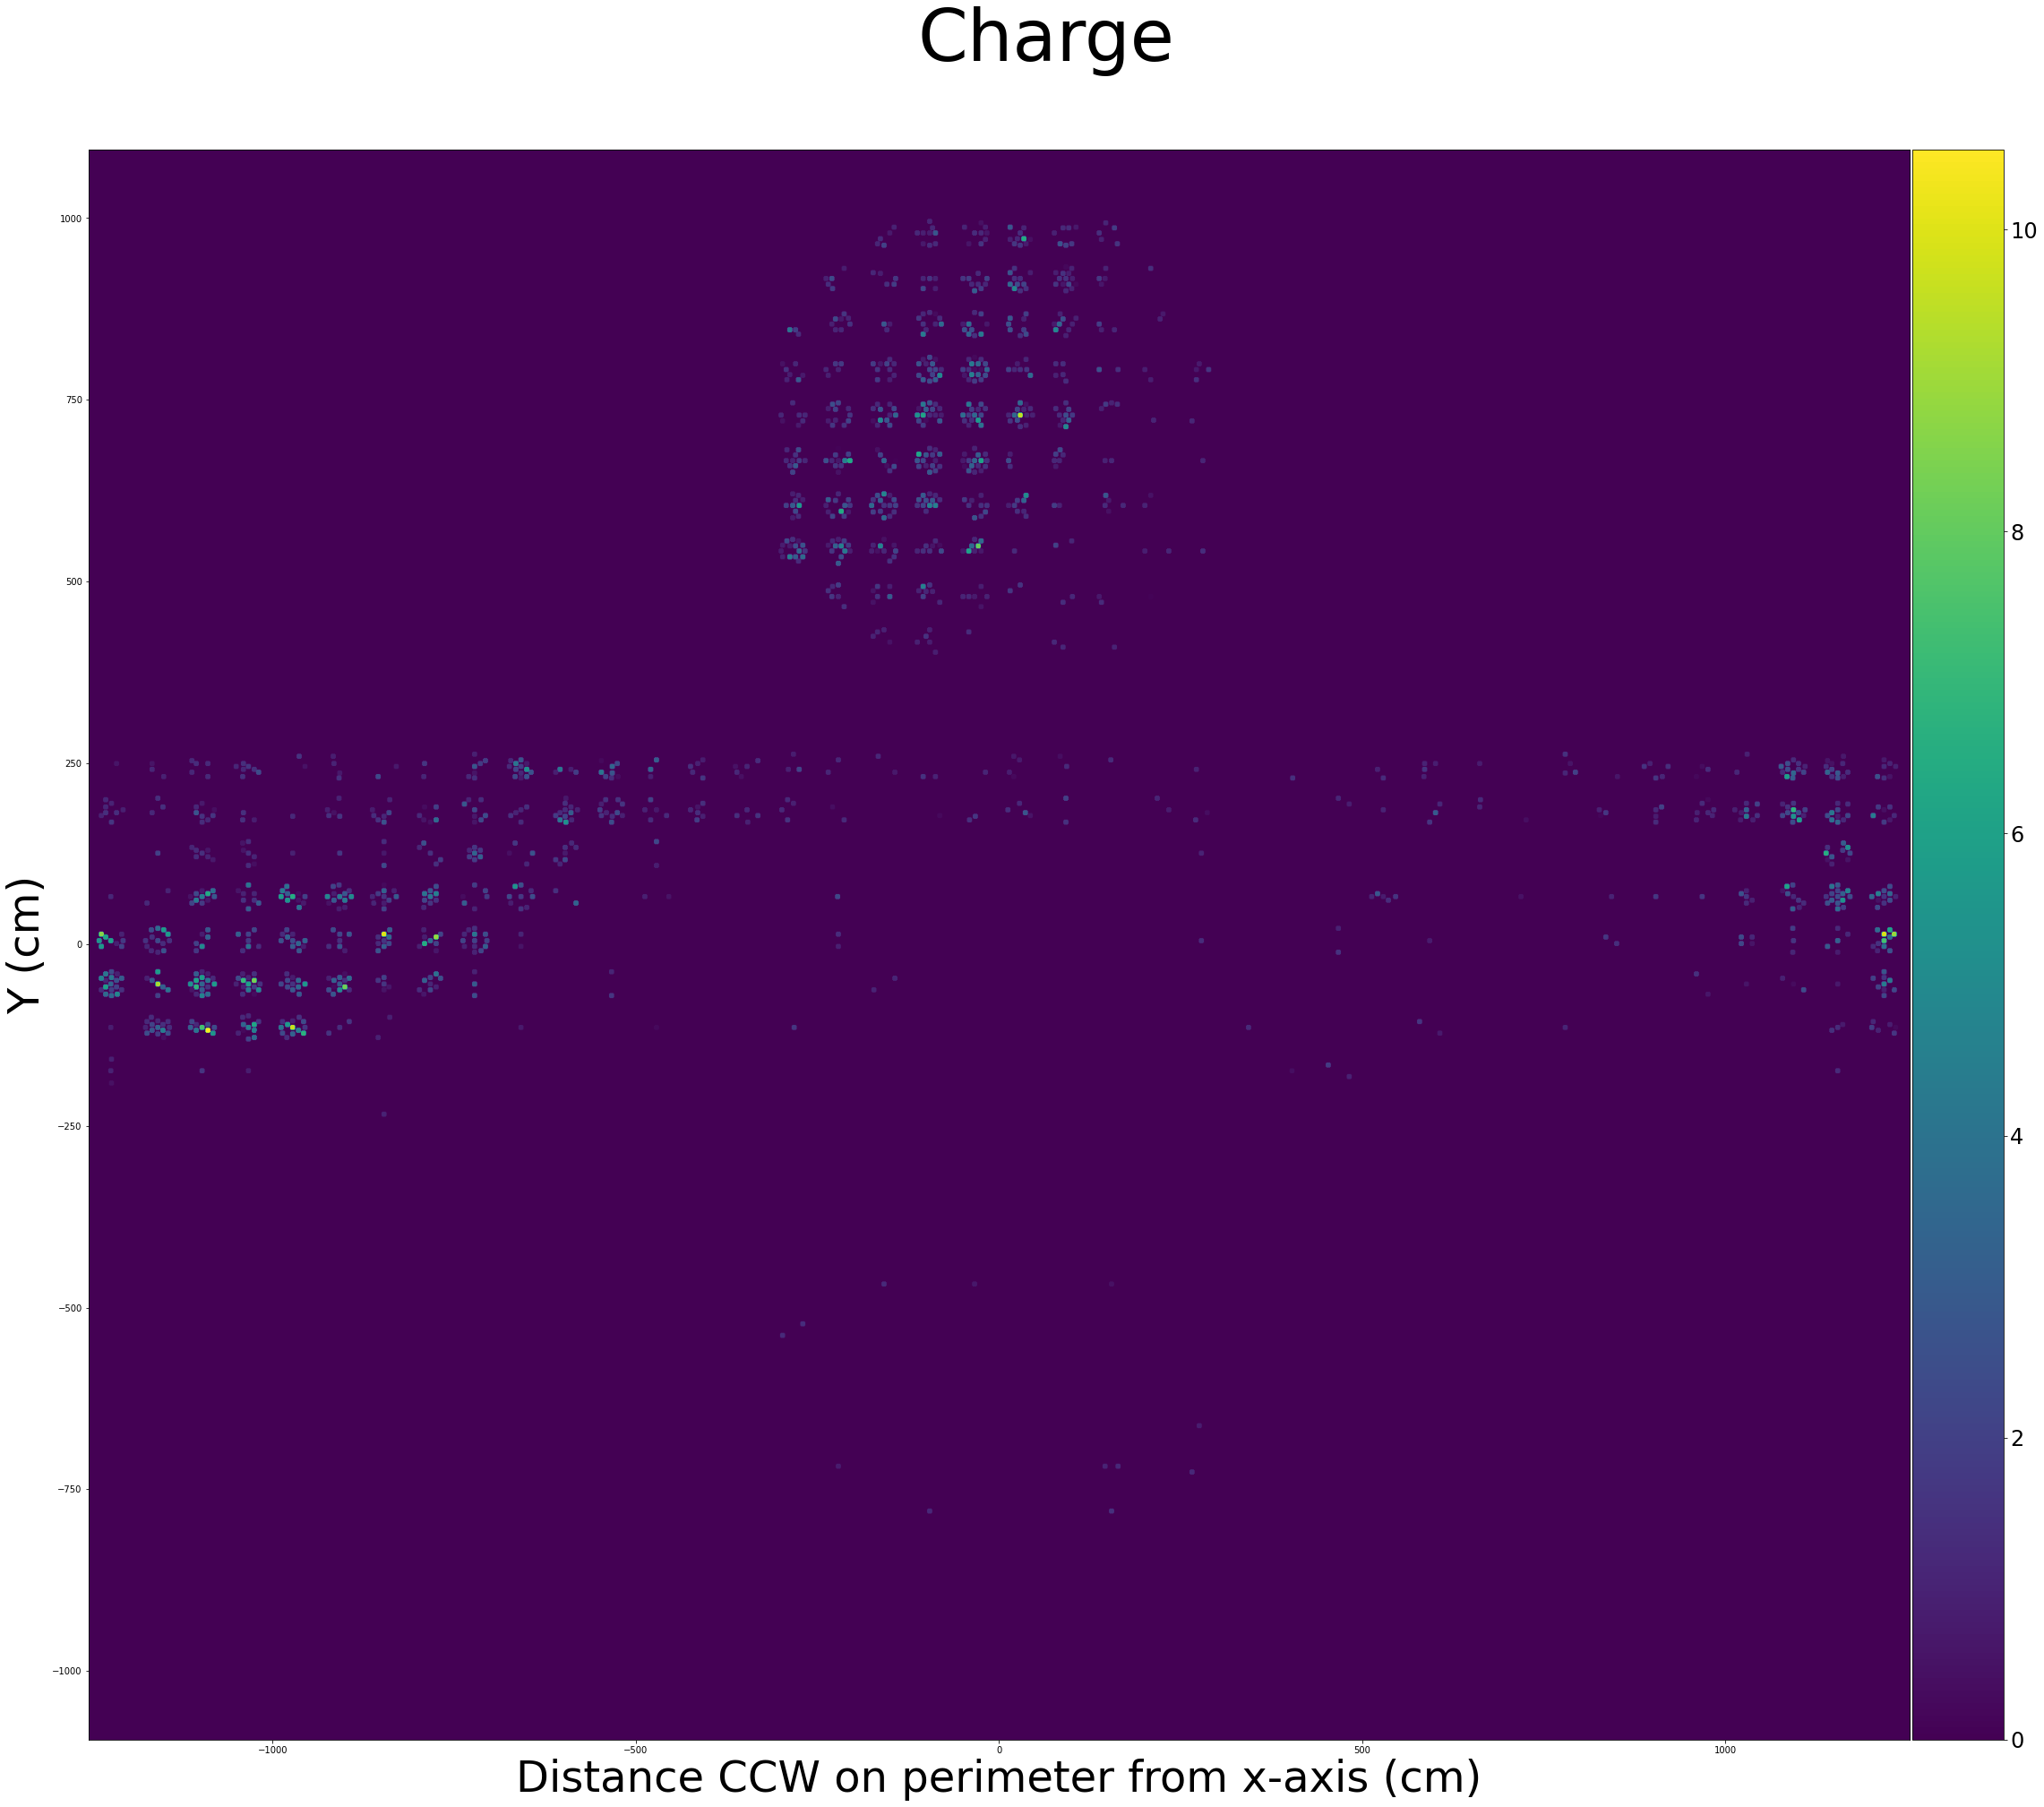

In [23]:
EventDisplay(test_event_pmts, test_event_charges, PMTFlatMapPositive)

# Inefficient Hit Charge Subset Construction

In [16]:
def get_event_PMTs(indices):
    pmt_charge = []
    pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
               ' ', ETA()], maxval=len(indices))

    pbar.start()
    for idx, i in enumerate(indices):
        pbar.update(idx)

        item = i #val_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        charge = hit_charge[start:stop]
        #print(charge)
        pmt_charge.extend(charge)
        #print(pmt_charge[0])
        #input()
    pbar.finish()

    #dataset_info[1]['pmt_charge'] = np.array(pmt_charge)
    return np.array(pmt_charge)

In [105]:
"""
# Get random subsets of pmts by dataset and particle
N_subset_events = 10000

train_g_pmt_subset = get_event_PMTs(np.random.choice(train_g_idxs, size=N_subset_events, replace=False))
val_g_pmt_subset   = get_event_PMTs(np.random.choice(val_g_idxs, size=N_subset_events, replace=False))
test_g_pmt_subset  = get_event_PMTs(np.random.choice(test_g_idxs, size=N_subset_events, replace=False))

train_e_pmt_subset = get_event_PMTs(np.random.choice(train_e_idxs, size=N_subset_events, replace=False))
val_e_pmt_subset   = get_event_PMTs(np.random.choice(val_e_idxs, size=N_subset_events, replace=False))
test_e_pmt_subset  = get_event_PMTs(np.random.choice(test_e_idxs, size=N_subset_events, replace=False))

train_m_pmt_subset = get_event_PMTs(np.random.choice(train_m_idxs, size=N_subset_events, replace=False))
val_m_pmt_subset   = get_event_PMTs(np.random.choice(val_m_idxs, size=N_subset_events, replace=False))
test_m_pmt_subset  = get_event_PMTs(np.random.choice(test_m_idxs, size=N_subset_events, replace=False))
"""

Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:12
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:09
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:14
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:14
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:08
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:13
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:21
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:09
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:22


In [106]:
"""
np.savez('./new_dataset_data/training_set_pmt_charge.npz', train_g_pmt_subset=train_g_pmt_subset,
                                                           train_e_pmt_subset=train_e_pmt_subset,
                                                           train_m_pmt_subset=train_m_pmt_subset)

np.savez('./new_dataset_data/validation_set_pmt_charge.npz', val_g_pmt_subset=val_g_pmt_subset,
                                                             val_e_pmt_subset=val_e_pmt_subset,
                                                             val_m_pmt_subset=val_m_pmt_subset)

np.savez('./new_dataset_data/test_set_pmt_charge.npz',  test_g_pmt_subset=test_g_pmt_subset,
                                                        test_e_pmt_subset=test_e_pmt_subset,
                                                        test_m_pmt_subset=test_m_pmt_subset)
"""

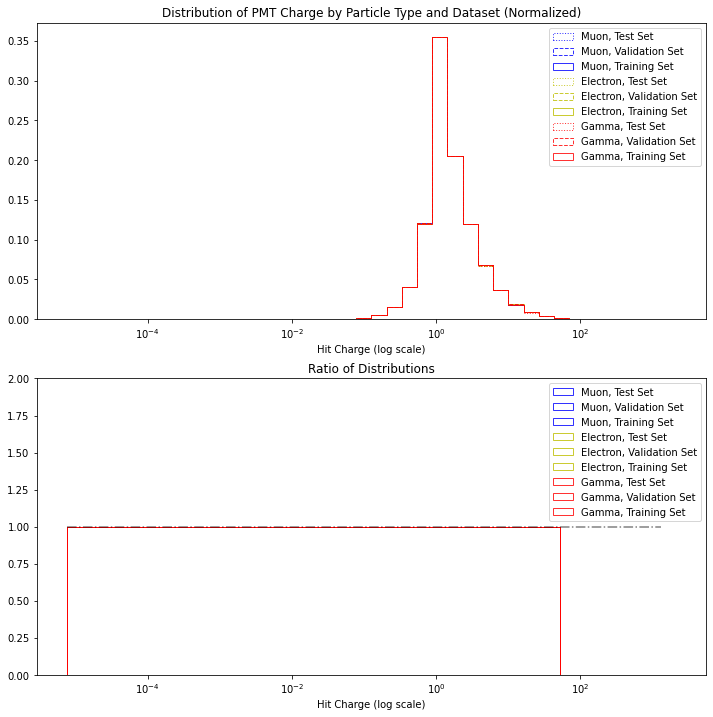

In [108]:
fig = plot_compare_dists([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                          train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                          train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=40,
                         ratio_range=[0,2],
                         title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'], 
                         xlabel='Hit Charge (log scale)',
                         xscale='log'
                    )


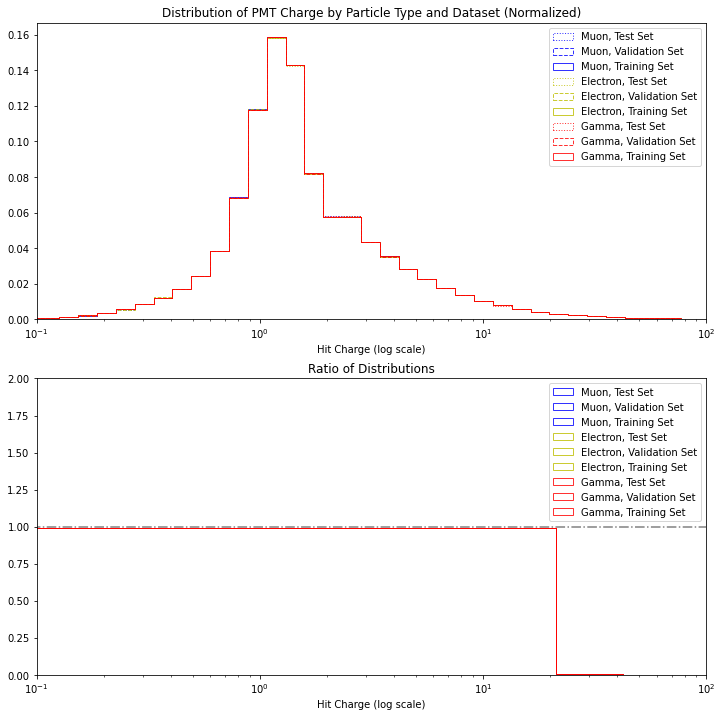

In [109]:
fig = plot_compare_dists([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                          train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                          train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=100,
                         ratio_range=[0,2],
                         title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'], 
                         xlabel='Hit Charge (log scale)',
                         xrange=[1e-1, 1e2],
                         xscale='log'
                    )


# Hit Charge by PMT

In [25]:
"Load subset data to get bins"
training_subsets = np.load('./new_dataset_data/training_set_pmt_charge.npz',allow_pickle=True) 
validation_subsets = np.load('./new_dataset_data/validation_set_pmt_charge.npz',allow_pickle=True)
test_subsets = np.load('./new_dataset_data/test_set_pmt_charge.npz',allow_pickle=True)

# Get random subsets of pmts by dataset and particle
N_subset_events = 1000

train_g_pmt_subset = training_subsets['train_g_pmt_subset']
val_g_pmt_subset   = validation_subsets['val_g_pmt_subset']
test_g_pmt_subset  = test_subsets['test_g_pmt_subset']

train_e_pmt_subset = training_subsets['train_e_pmt_subset']
val_e_pmt_subset   = validation_subsets['val_e_pmt_subset']
test_e_pmt_subset  = test_subsets['test_e_pmt_subset']

train_m_pmt_subset = training_subsets['train_m_pmt_subset']
val_m_pmt_subset   = validation_subsets['val_m_pmt_subset']
test_m_pmt_subset  = test_subsets['test_m_pmt_subset']


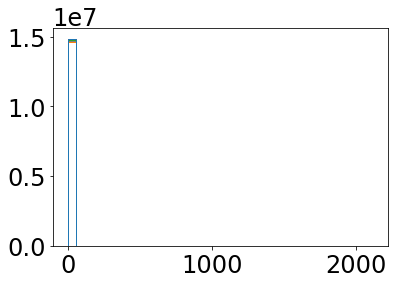

In [26]:
__, plot_bins, __ = plt.hist([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                              train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                              train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                             histtype=u'step',
                             bins=40)

plot_bins = np.logspace(np.log10(plot_bins[0]), np.log10(plot_bins[-1]), 40 + 1)

In [29]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook as tqdm

def get_large_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    
    hist = np.zeros(len(bins)-1)
    description = '{} Progress: '.format(name)
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_charge[start:stop]

        temp_hist, _ = np.histogram(np.clip(hit_data, bins[0], bins[-1]), bins)
        hist += temp_hist

    return hist

In [45]:
from multiprocessing import Process, Pool
# Get multiple progress bars
# Get return values of all processes
test_train_e_idxs = train_e_idxs
test_train_g_idxs = train_g_idxs

def get_large_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    results = pool.starmap(get_large_hist, arg_list)
    return results

In [57]:
test_large_plot_inputs = [test_train_g_idxs[0:1000], test_train_e_idxs[0:1000]]
test_large_plot_names = ['train_g', 'train_e']

test_outputs = get_large_hists(test_large_plot_inputs, plot_bins, test_large_plot_names)

No handles with labels found to put in legend.


labels:  ['Gamma, Validation Set', 'Electron, Training Set']


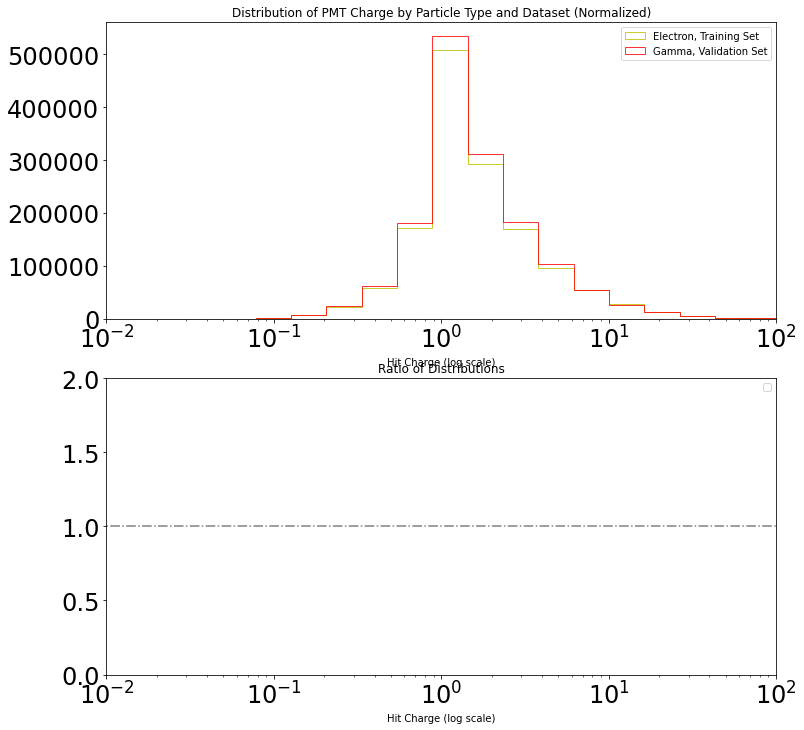

In [74]:
from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import plot_computed_dists

plot_computed_dists(test_outputs, 
                    bins=plot_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=['Gamma, Validation Set', 'Electron, Training Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)', 
                    colors =  ['r','y'],
                    linestyle=['-','-'], 
                    xlabel='Hit Charge (log scale)',
                    xscale='log',
                    xrange=[1e-2, 1e2]
                   )

In [50]:
# Get hist data for full dataset
large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

outputs = get_large_hists(large_plot_inputs, plot_bins, large_plot_names)

No handles with labels found to put in legend.


labels:  ['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set', 'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set', 'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set']


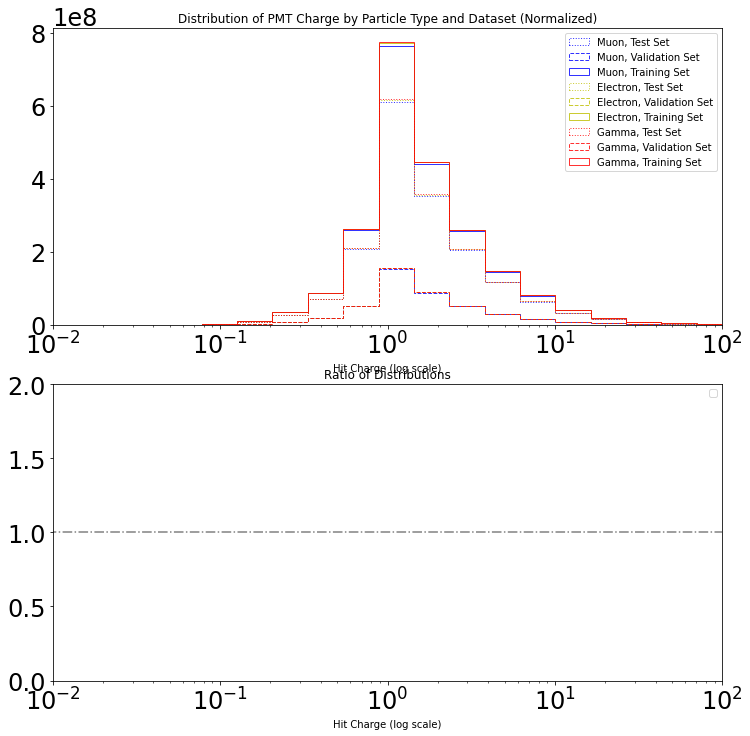

In [75]:
plot_computed_dists(outputs, 
                    bins=plot_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Charge (log scale)',
                    xscale='log',
                    xrange=[1e-2, 1e2]
                   )

# Inefficient Hit Times Subset Construction

In [48]:
def get_event_hit_times(indices):
    pmt_times = []
    pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
               ' ', ETA()], maxval=len(indices))

    pbar.start()
    for idx, i in enumerate(indices):
        pbar.update(idx)

        item = i #val_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        times  = hit_time[start:stop]
        #print(charge)
        pmt_times.extend(times)
        #print(pmt_charge[0])
        #input()
    pbar.finish()

    #dataset_info[1]['pmt_charge'] = np.array(pmt_charge)
    return np.array(pmt_times)

In [110]:
"""
# Get random subsets of pmts by dataset and particle
N_subset_events = 10000

train_g_times_subset = get_event_hit_times(np.random.choice(train_g_idxs, size=N_subset_events, replace=False))
val_g_times_subset   = get_event_hit_times(np.random.choice(val_g_idxs, size=N_subset_events, replace=False))
test_g_times_subset  = get_event_hit_times(np.random.choice(test_g_idxs, size=N_subset_events, replace=False))

train_e_times_subset = get_event_hit_times(np.random.choice(train_e_idxs, size=N_subset_events, replace=False))
val_e_times_subset   = get_event_hit_times(np.random.choice(val_e_idxs, size=N_subset_events, replace=False))
test_e_times_subset  = get_event_hit_times(np.random.choice(test_e_idxs, size=N_subset_events, replace=False))

train_m_times_subset = get_event_hit_times(np.random.choice(train_m_idxs, size=N_subset_events, replace=False))
val_m_times_subset   = get_event_hit_times(np.random.choice(val_m_idxs, size=N_subset_events, replace=False))
test_m_times_subset  = get_event_hit_times(np.random.choice(test_m_idxs, size=N_subset_events, replace=False))
"""

Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:01:17
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:36
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:59
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:01:05
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:25
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:29
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:01:07
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:22
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:48


In [111]:
"""
np.savez('./new_dataset_data/training_set_times_subset.npz', train_g_times_subset=train_g_times_subset,
                                                           train_e_times_subset=train_e_times_subset,
                                                           train_m_times_subset=train_m_times_subset)

np.savez('./new_dataset_data/validation_times_subset.npz', val_g_times_subset=val_g_times_subset,
                                                             val_e_times_subset=val_e_times_subset,
                                                             val_m_times_subset=val_m_times_subset)

np.savez('./new_dataset_data/test_set_times_subset.npz',  test_g_times_subset=test_g_times_subset,
                                                        test_e_times_subset=test_e_times_subset,
                                                        test_m_times_subset=test_m_times_subset)
"""

In [76]:
training_times_subset = np.load('./new_dataset_data/training_set_times_subset.npz',allow_pickle=True) 
validation_times_subset = np.load('./new_dataset_data/validation_times_subset.npz',allow_pickle=True)
test_times_subset = np.load('./new_dataset_data/test_set_times_subset.npz',allow_pickle=True)

train_g_times_subset = training_times_subset['train_g_times_subset']
val_g_times_subset   = validation_times_subset['val_g_times_subset']
test_g_times_subset  = test_times_subset['test_g_times_subset']

train_e_times_subset = training_times_subset['train_e_times_subset']
val_e_times_subset   = validation_times_subset['val_e_times_subset']
test_e_times_subset  = test_times_subset['test_e_times_subset']

train_m_times_subset = training_times_subset['train_m_times_subset']
val_m_times_subset   = validation_times_subset['val_m_times_subset']
test_m_times_subset  = test_times_subset['test_m_times_subset']


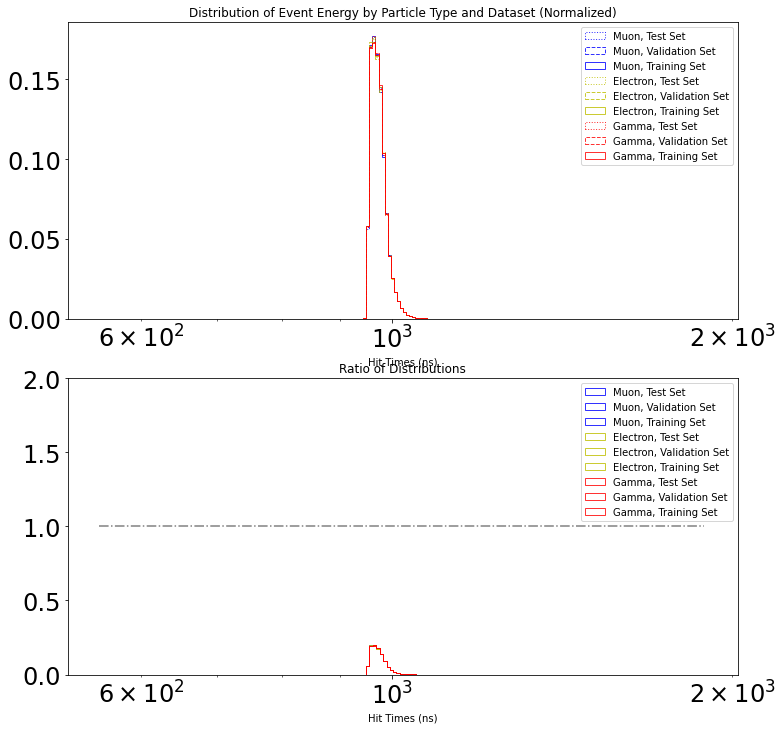

In [77]:
fig = plot_compare_dists([train_g_times_subset, val_g_times_subset, test_g_times_subset, 
                          train_e_times_subset, val_e_times_subset, test_e_times_subset,
                          train_m_times_subset, val_m_times_subset, test_m_times_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=200,
                         ratio_range=[0,2],
                         title='Distribution of Event Energy by Particle Type and Dataset (Normalized)', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'], 
                         xlabel='Hit Times (ns)',
                         xscale='log'
                    )

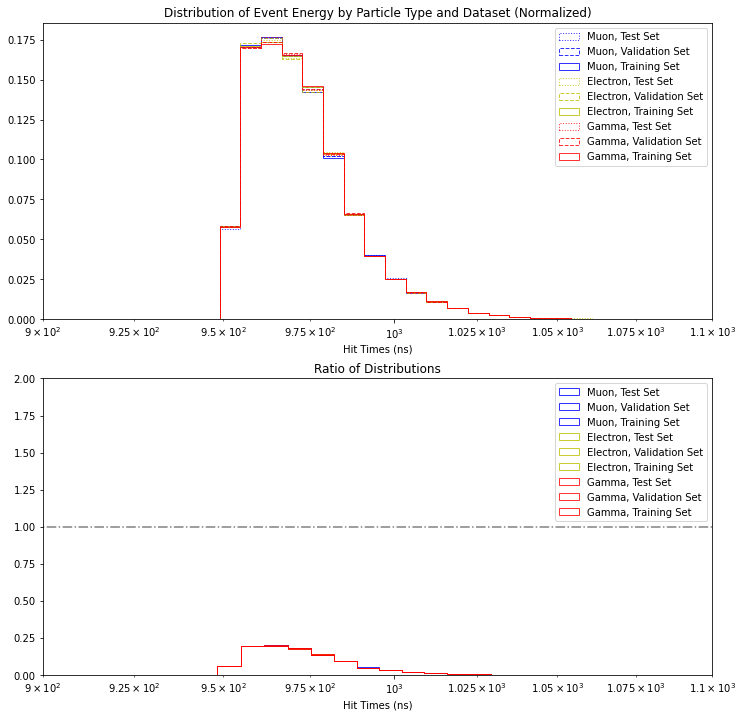

In [113]:
fig = plot_compare_dists([train_g_times_subset, val_g_times_subset, test_g_times_subset, 
                          train_e_times_subset, val_e_times_subset, test_e_times_subset,
                          train_m_times_subset, val_m_times_subset, test_m_times_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=200,
                         xrange=[900, 1100],
                         ratio_range=[0,2],
                         title='Distribution of Event Energy by Particle Type and Dataset (Normalized)', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'], 
                         xlabel='Hit Times (ns)',
                         xscale='log'
                    )

# Hit Times

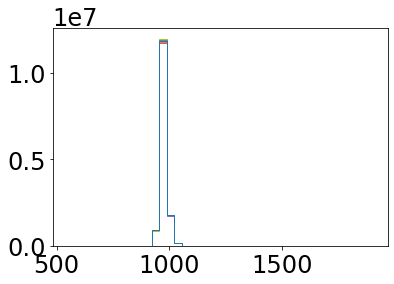

In [88]:
ns, time_plot_bins, __ = plt.hist([train_g_times_subset, val_g_times_subset, test_g_times_subset, 
                              train_e_times_subset, val_e_times_subset, test_e_times_subset,
                              train_m_times_subset, val_m_times_subset, test_m_times_subset],
                             histtype=u'step',
                             bins=40)

time_plot_bins = np.logspace(np.log10(time_plot_bins[0]), np.log10(time_plot_bins[-1]), 40 + 1)

In [82]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook as tqdm

def get_large_times_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    
    hist = np.zeros(len(bins)-1)
    description = '{} Progress: '.format(name)
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_time[start:stop]

        temp_hist, _ = np.histogram(np.clip(hit_data, bins[0], bins[-1]), bins)
        hist += temp_hist

    return hist

In [83]:
def get_large_times_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    results = pool.starmap(get_large_times_hist, arg_list)
    return results

In [84]:
test_time_large_plot_inputs = [test_train_g_idxs[0:1000], test_train_e_idxs[0:1000]]
test_time_large_plot_names = ['train_g', 'train_e']

test_time_outputs = get_large_hists(test_time_large_plot_inputs, time_plot_bins, test_time_large_plot_inputs)

No handles with labels found to put in legend.


labels:  ['Gamma, Validation Set', 'Electron, Training Set']


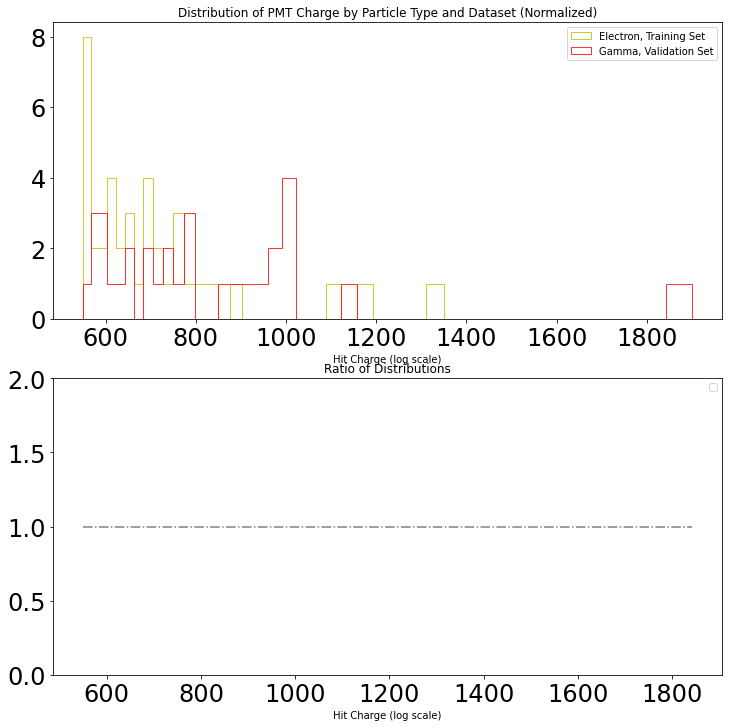

In [87]:
plot_computed_dists(test_time_outputs, 
                    bins=plot_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=['Gamma, Validation Set', 'Electron, Training Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)', 
                    colors =  ['r','y'],
                    linestyle=['-','-'], 
                    xlabel='Hit Charge (log scale)'
                   )

In [ ]:
# Get hist data for full dataset
time_large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

time_large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

time_outputs = get_large_hists(time_large_plot_inputs, plot_bins, time_large_plot_names)

In [ ]:
plot_computed_dists(outputs, 
                    bins=plot_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Charge (log scale)',
                    xscale='log',
                    xrange=[1e-2, 1e2]
                   )

# Times Thresholded by Charge

In [ ]:
energy_bins = []

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]  
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]


def get_idxs_satisfying_bounds(energies, lower_bound, upper_bound):
    return np.where((lower_bound < energies) & (energies <= upper_bound))[0]

valid_train_m_energy_idxs = get_idxs_satisfying_bounds(train_m_energies, 400, 500)
valid_val_m_energy_idxs   = get_idxs_satisfying_bounds(val_m_energies, 400, 500)
valid_test_m_energy_idxs  = get_idxs_satisfying_bounds(test_m_energies, 400, 500)

# print((dataset_info[0]['energies'])[train_m_idxs[valid_train_m_energy_idxs]])

train_bin_dist_to_wall = (dataset_info[0]['d_to_wall'])[train_m_idxs[valid_train_m_energy_idxs]]
val_bin_dist_to_wall   = (dataset_info[1]['d_to_wall'])[val_m_idxs[valid_val_m_energy_idxs]]
test_bin_dist_to_wall  = (dataset_info[2]['d_to_wall'])[test_m_idxs[valid_test_m_energy_idxs]]

plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()

plot_compare_dists(np.squeeze(np.array([train_bin_dist_to_wall, 
                                        val_bin_dist_to_wall, 
                                        test_bin_dist_to_wall])),
                    bins=30,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[data['name'] for data in dataset_info],
                    title='Distribution of Distance to Wall Along Particle Trajectory for $400$-$500$ MeV Events',
                    axes = axes,
                    xlabel='Distance (cm)',
                    normalized=False
                    )